In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Colab Notebooks/Artificial NN & Deep Learning/Assignment 1

!pip install -q keras-cv tensorflow
!pip install -q keras-cv tensorflow
!pip install -q keras

Mounted at /gdrive
/gdrive/MyDrive/Colab Notebooks/Artificial NN & Deep Learning/Assignment 1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 34.8 MB/s eta 0:00:00


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from keras_cv.layers import Augmenter
import tensorflow as tf
import keras_cv
from tqdm import tqdm

In [6]:
file_path = 'Clean_Dataset.npz'

with np.load(file_path) as data:
    training_images = data['images']
    training_labels = data['labels']

# Check
print(f"Shape of images: {training_images.shape}")
print(f"type of images: {type(training_images)}")
print(f"shape of labels: {training_labels.shape}")
print(f"type of labels: {type(training_labels)}")
print("-----------------------------------------------------")
# Dataframe for labels
labels = training_labels.flatten()
df_labels = pd.DataFrame(labels, columns=['label'])
print(df_labels.head())
print("-----------------------------------------------------")

####

# train test val split
from sklearn.model_selection import train_test_split

# Define split sizes
validation_size = 0.15

# Split into training and validation sets [NO TEST SET HERE]
training_labels = training_labels.flatten()
X_train, X_val, y_train, y_val = train_test_split(
    training_images,
    training_labels,
    test_size=validation_size,
    random_state=42,
    stratify=training_labels
)

print("Training Images - Min pixel value:", np.min(X_train))
print("Training Images - Max pixel value:", np.max(X_train))
print("Validation Images - Min pixel value:", np.min(X_val))
print("Validation Images - Max pixel value:", np.max(X_val))
print("-----------------------------------------------------")
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print("-----------------------------------------------------")

####

class_counts = pd.Series(y_train).value_counts()  # Use only y_train, not the full label set

# `class_counts` now contains the size of each class:
# - `class_counts[j]` gives the count of items with class label `j`.

max_count = class_counts.max()
print(f"Maximum class count: {max_count}")

# Initialize lists to hold oversampled data
X_train_oversampled = []
y_train_oversampled = []

# Iterate through each class to perform oversampling
for class_label in class_counts.index:
    # Current class samples
    X_class = X_train[y_train == class_label]
    y_class = y_train[y_train == class_label]

    # Number of samples to add
    samples_needed = max_count - len(X_class)

    if samples_needed > 0:
        # Calculate how many times to duplicate the class samples
        duplicates = samples_needed // len(X_class)
        remainder = samples_needed % len(X_class)

        # Duplicate the entire class as many times as needed
        for _ in range(duplicates):
            X_train_oversampled.append(X_class)
            y_train_oversampled.append(y_class)

        # Add the remaining samples by randomly selecting from the class
        if remainder > 0:
            indices = np.random.choice(len(X_class), size=remainder, replace=True)
            X_train_oversampled.append(X_class[indices])
            y_train_oversampled.append(y_class[indices])

# Concatenate the oversampled data
if X_train_oversampled:
    X_train_oversampled = np.vstack(X_train_oversampled)
    y_train_oversampled = np.hstack(y_train_oversampled)

    # Append the oversampled data to the original training set
    X_train_balanced = np.vstack((X_train, X_train_oversampled))
    y_train_balanced = np.hstack((y_train, y_train_oversampled))
else:
    # If no oversampling is needed
    X_train_balanced = X_train
    y_train_balanced = y_train

print(f"Training set shape after oversampling: {X_train_balanced.shape}, {y_train_balanced.shape}")

Shape of images: (11943, 96, 96, 3)
type of images: <class 'numpy.ndarray'>
shape of labels: (11943, 1)
type of labels: <class 'numpy.ndarray'>
-----------------------------------------------------
   label
0      7
1      3
2      6
3      6
4      7
-----------------------------------------------------
Training Images - Min pixel value: 0
Training Images - Max pixel value: 255
Validation Images - Min pixel value: 0
Validation Images - Max pixel value: 255
-----------------------------------------------------
Training set shape: (10151, 96, 96, 3), (10151,)
Validation set shape: (1792, 96, 96, 3), (1792,)
-----------------------------------------------------
Maximum class count: 1980
Training set shape after oversampling: (15840, 96, 96, 3), (15840,)


## If you want to apply AugMix to your training dataset :
- It takes around 15' ;
- Execute only if you want to apply AugMix ;
- If you have already saved an AugMix-augmented dataset in your drive, you can execute the cell after this one.

100%|██████████| 15840/15840 [34:03<00:00,  7.75it/s]


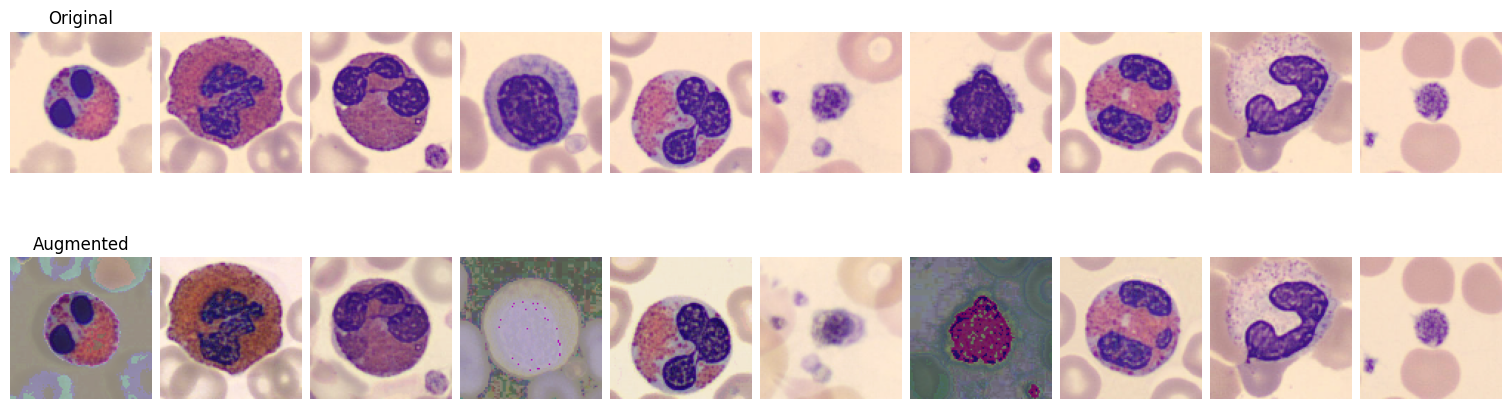

In [ ]:
# Define augmentation
augmentation = keras_cv.layers.AugMix(value_range=[0, 1])

# Load and normalize images in X_train_balanced
X_train_augmented = []

# Apply AugMix to each image in X_train_balanced
for img in tqdm(X_train_balanced):
    # Normalize pixel values to [0, 1]
    img = np.array(img) / 255.0
    # Apply augmentation
    augmented_img = augmentation(img)
    # Clip to keep pixel values in [0, 1]
    augmented_img = np.clip(augmented_img, 0., 1.)
    # Add to augmented dataset
    X_train_augmented.append(augmented_img)

# Convert the list back to a numpy array if needed
X_train_augmented = np.array(X_train_augmented)

# Visualize a sample of original and augmented images
def plot_original_vs_augmented(X_original, X_augmented, num_images=10):
    fig = plt.figure(constrained_layout=True, figsize=(15, 4))
    gs = gridspec.GridSpec(2, num_images, figure=fig, hspace=0.3)

    for i in range(num_images):
        # Original image
        ax1 = fig.add_subplot(gs[0, i])
        ax1.imshow(np.squeeze(X_original[i]))
        ax1.axis('off')
        if i == 0:
            ax1.set_title("Original")

        # Augmented image
        ax2 = fig.add_subplot(gs[1, i])
        ax2.imshow(np.squeeze(X_augmented[i]))
        ax2.axis('off')
        if i == 0:
            ax2.set_title("Augmented")

    plt.show()

# Plot the original vs augmented images
plot_original_vs_augmented(X_train_balanced, X_train_augmented)

# Let's save all the sets so that we can use it later :
np.save('X_train_augmented_V2.npy', X_train_augmented)
np.save('X_train_balanced_V2.npy', X_train_balanced)
np.save('y_train_balanced_V2.npy', y_train_balanced)
np.save('X_val_V2.npy', X_val)
np.save('y_val_V2.npy', y_val)

## Import previously AugMix-augmented training dataset :
- It imports the augmented dataset that you previously saved in you drive.

In [9]:
X_train_augmented = np.load("X_train_augmented_V2.npy")
y_train_balanced = np.load("y_train_balanced_V2.npy")
X_val = np.load("X_val_V2.npy")
y_val = np.load("y_val_V2.npy")
X_train_balanced = np.load("X_train_balanced_V2.npy")

X_train_augmented.max(), X_train_augmented.min(), X_train_balanced.max(), X_train_balanced.min(), X_val.max(), X_val.min()
# Should be : 1, 0, 255, 0, 255, 0, 255, 0

(1.0, 0.0, 255, 0, 255, 0)

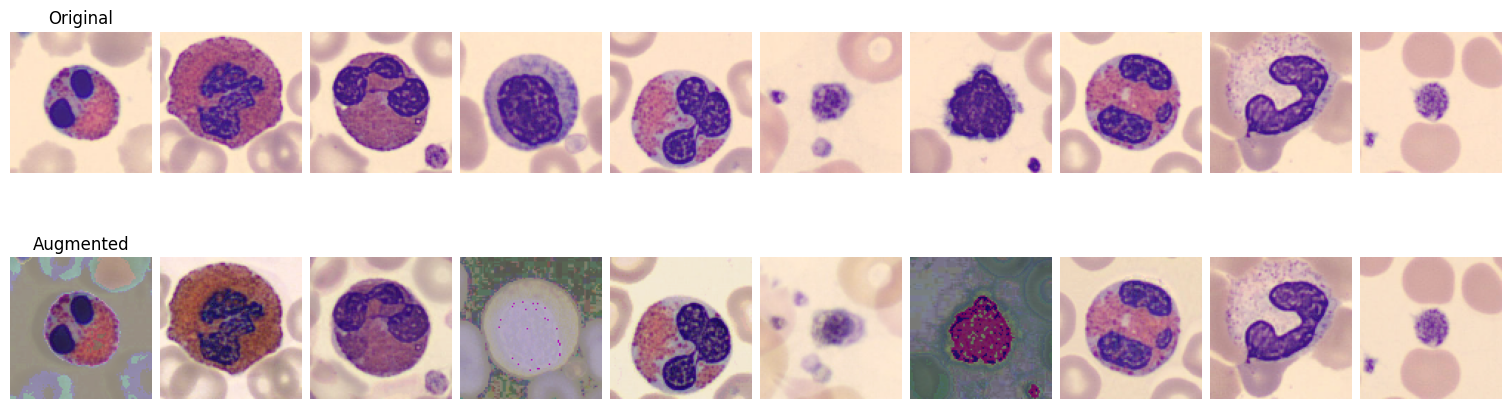

In [10]:
# Visualize a sample of original and augmented images
def plot_original_vs_augmented(X_original, X_augmented, num_images=10):
    fig = plt.figure(constrained_layout=True, figsize=(15, 4))
    gs = gridspec.GridSpec(2, num_images, figure=fig, hspace=0.3)

    for i in range(num_images):
        # Original image
        ax1 = fig.add_subplot(gs[0, i])
        ax1.imshow(np.squeeze(X_original[i]))
        ax1.axis('off')
        if i == 0:
            ax1.set_title("Original")

        # Augmented image
        ax2 = fig.add_subplot(gs[1, i])
        ax2.imshow(np.squeeze(X_augmented[i]))
        ax2.axis('off')
        if i == 0:
            ax2.set_title("Augmented")

    plt.show()

# Plot the original vs augmented images
plot_original_vs_augmented(X_train_balanced, X_train_augmented)

## CHECK about the scaling :

In [11]:
X_train_augmented.max(), X_train_augmented.min(), X_train_balanced.max(), X_train_balanced.min(), X_val.max(), X_val.min()
# It should be : 1, 0, 255, 0, 255, 0

(1.0, 0.0, 255, 0, 255, 0)

In [12]:
# CHECK if it's between 0 and 1 or between 0 and 255 for the training augmented dataset.
# Ensure that it's the same for val and test.
X_train_augmented = X_train_augmented * 255 # Rescaling because the AugMix made it between 0 and 1.

In [13]:
X_train_augmented.max(), X_train_augmented.min(), X_train_balanced.max(), X_train_balanced.min(), X_val.max(), X_val.min()
# It should be : 255, 0, 255, 0, 255, 0

(255.0, 0.0, 255, 0, 255, 0)

## Build the "real" training / validation sets :
- With AugMix + classical augmentations (added here).

In [14]:
# Add classical augmentations :
import numpy as np
import tensorflow as tf
import keras_cv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm

# Define classical augmentations (rotation, flip, zoom, etc.)
def apply_classical_augmentation(image):
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)

    # Random vertical flip
    image = tf.image.random_flip_up_down(image)

    # Random rotation between -20 and 20 degrees (converted to radians)
    image = tf.image.rot90(image, k=tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32))  # Random 90 degree rotations

    # Random zoom (scaling)
    image = tf.image.resize(image, [int(image.shape[0] * tf.random.uniform([], minval=0.8, maxval=1.2)),
                                    int(image.shape[1] * tf.random.uniform([], minval=0.8, maxval=1.2))])
    image = tf.image.resize(image, [299, 299])  # Resize back to target size

    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.2)

    # Random contrast
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)

    return image

# Define preprocessing step
def preprocess(image, label):
    # Apply classical augmentation before preprocessing
    # image = apply_classical_augmentation(image)

    # Convert image to float32
    image = tf.cast(image, tf.float32)

    # Get image dimensions
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]

    # Determine crop size (smallest dimension)
    crop_size = tf.minimum(height, width)

    # Calculate offsets for center cropping
    height_offset = (height - crop_size) // 2
    width_offset = (width - crop_size) // 2

    # Center-crop and resize image to 299x299
    image = tf.image.crop_to_bounding_box(
        image,
        height_offset,
        width_offset,
        crop_size,
        crop_size
    )
    image = tf.image.resize(image, [299, 299])

    # Normalize pixel values to [0, 1]
    image = image / 255.0
    return image, label

# Function to prepare data by applying preprocessing and augmentations
def prepare_data(X_data, y_data):
    # Define image shape after preprocessing
    img_shape = (299, 299, 3)

    # Initialize arrays to store processed data
    X_processed = np.zeros((len(X_data), *img_shape), dtype=np.float32)
    y_processed = np.array(y_data, dtype=np.int64)

    # Batch-process and store data
    batch_size = 32
    dataset = tf.data.Dataset.from_tensor_slices((X_data, y_data))
    dataset = dataset.map(preprocess).batch(batch_size)

    idx = 0
    for batch_images, batch_labels in dataset:
        batch_size = batch_images.shape[0]
        X_processed[idx:idx + batch_size] = batch_images.numpy()
        y_processed[idx:idx + batch_size] = batch_labels.numpy()
        idx += batch_size

        # Optional: print progress for processing data
        if idx % 500 == 0:
            print(f"Processed {idx}/{len(X_data)} images")

    return X_processed, y_processed

# Augmenting and preprocessing training data
X_train, y_train = prepare_data(X_train_augmented, y_train_balanced)
X_val, y_val = prepare_data(X_val, y_val)

# Display data shapes for training, validation, and test sets
print("Training set shape (images):", X_train.shape)
print("Training set shape (labels):", y_train.shape)
print("Validation set shape (images):", X_val.shape)
print("Validation set shape (labels):", y_val.shape)

Processed 4000/15840 images
Processed 8000/15840 images
Processed 12000/15840 images
Training set shape (images): (15840, 299, 299, 3)
Training set shape (labels): (15840,)
Validation set shape (images): (1792, 299, 299, 3)
Validation set shape (labels): (1792,)


In [16]:
X_train.max(), X_train.min(), X_val.max(), X_val.min()
# It should be around 1, 0, 1, 0

(1.0, 6.0476825e-05, 1.0, 0.015315766)

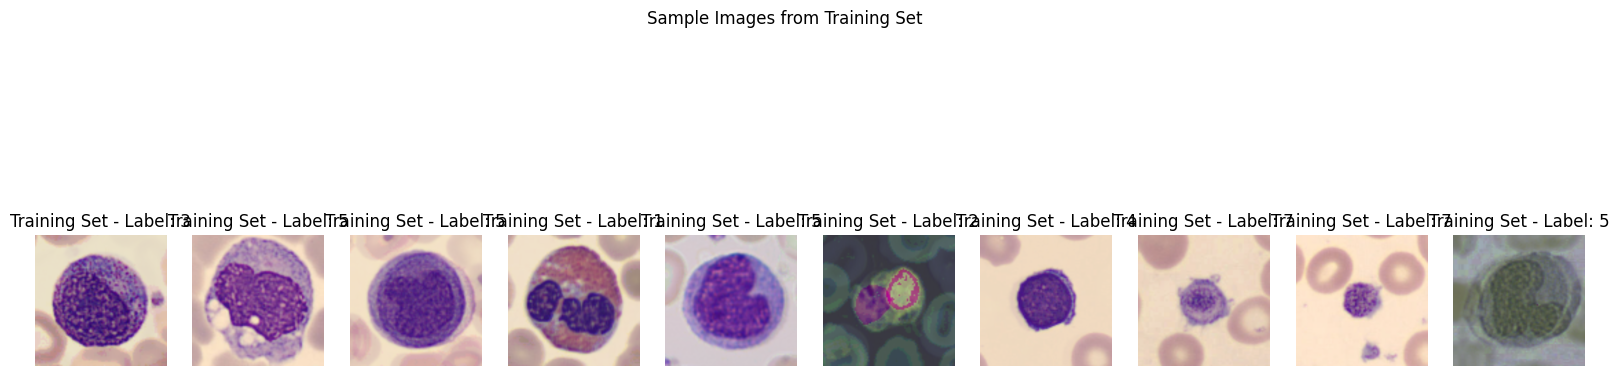

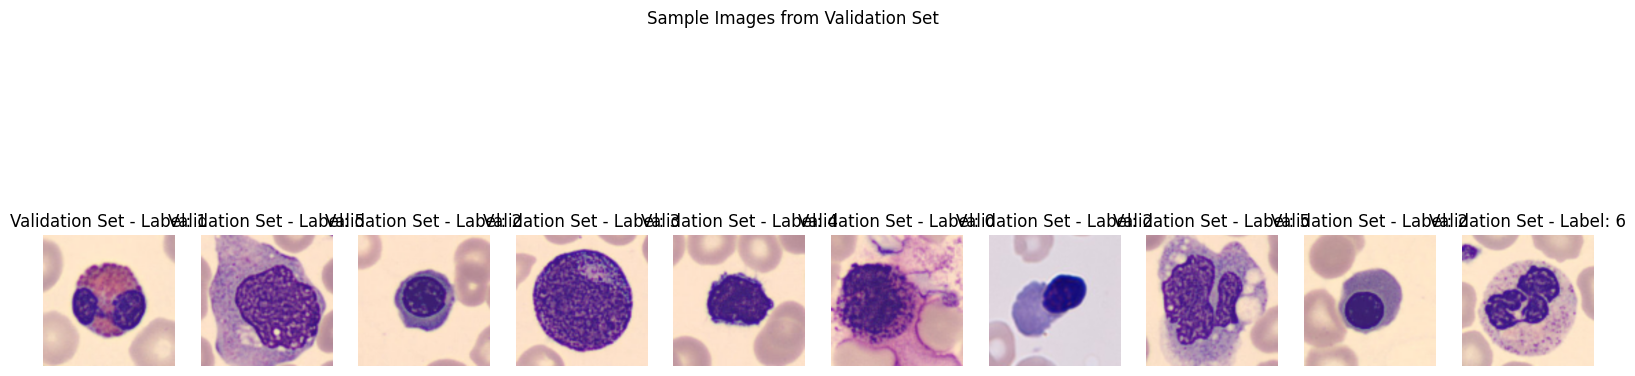

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_samples(X_data, y_data, dataset_name, num_samples=10):
    """
    Plots a few samples from the given dataset.

    Args:
    - X_data (np.ndarray): The dataset of images.
    - y_data (np.ndarray): The labels corresponding to the images.
    - dataset_name (str): Name of the dataset to display in the title.
    - num_samples (int): Number of samples to display.
    """
    plt.figure(figsize=(20, 6))
    indices = np.random.choice(len(X_data), num_samples, replace=False)

    for i, idx in enumerate(indices):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(X_data[idx])
        plt.title(f"{dataset_name} - Label: {y_data[idx]}")
        plt.axis("off")

    plt.suptitle(f"Sample Images from {dataset_name}")
    plt.show()

# Plot samples from each dataset
plot_samples(X_train, y_train, "Training Set")
plot_samples(X_val, y_val, "Validation Set")

## Build y_train & y_val :
- They contain the labels.

In [18]:
from tensorflow import keras as tfk

# Convert class labels to categorical format for training, validation, and test sets
y_train = tfk.utils.to_categorical(y_train, num_classes=8)
y_val = tfk.utils.to_categorical(y_val, num_classes=8)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (15840, 299, 299, 3), y_train shape: (15840, 8)
X_val shape: (1792, 299, 299, 3), y_val shape: (1792, 8)


## Transfer Learning :

In [19]:
# Choose the filename for when you save the model :
model_filename = 'MobileNetV3Large_Benchmark_0_80.keras'

In [20]:
# Initialise model with pretrained weights, for transfer learning
mobilenet = tfk.applications.MobileNetV3Large(
    input_shape=(299, 299, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
    include_preprocessing=True
)
# mobilenet.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
from tensorflow.keras import layers as tfkl

# Freeze all layers in the model to use it solely as a feature extractor
mobilenet.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=(299, 299, 3), name='input_layer')

# Apply data augmentation for training robustness
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal"),
    tfkl.RandomTranslation(0.2, 0.2)
], name='preprocessing')

x = augmentation(inputs)

# Pass augmented inputs through the model feature extractor
x = mobilenet(x)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Lion(), metrics=['accuracy'])

In [22]:
# Train the model
tl_history = tl_model.fit(
    x=X_train * 255,
    y=y_train,
    batch_size=32,
    epochs=20, # NORMALLY : 200
    validation_data=(X_val * 255, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
tl_model.save(model_filename)

# Free memory by deleting the model instance
del tl_model

Epoch 1/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.5962 - loss: 1.1784 - val_accuracy: 0.9202 - val_loss: 0.2565
Epoch 2/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.7967 - loss: 0.6517 - val_accuracy: 0.9297 - val_loss: 0.2234
Epoch 3/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.8094 - loss: 0.6391 - val_accuracy: 0.9152 - val_loss: 0.2783
Epoch 4/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.8183 - loss: 0.6204 - val_accuracy: 0.9169 - val_loss: 0.2606
Epoch 5/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.8142 - loss: 0.6475 - val_accuracy: 0.9431 - val_loss: 0.2003
Epoch 6/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.8144 - loss: 0.6447 - val_accuracy: 0.9342 - val_loss: 0.2158
Epoch 7/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.8203 - loss: 0.6406 - val_accuracy: 0.9408 - val_loss: 0.1914
Epoch 8/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.8172 - loss: 0.6375 - 

## FINE TUNING :

In [23]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model(model_filename)

In [24]:
## ADAPT THIS IF YOU CHANGE THE MODEL :

# Set the model layers as trainable
ft_model.get_layer('MobileNetV3Large').trainable = True

# Set all model layers as non-trainable
for layer in ft_model.get_layer('MobileNetV3Large').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('MobileNetV3Large').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

2 conv Conv2D True
5 expanded_conv_depthwise DepthwiseConv2D True
8 expanded_conv_project Conv2D True
11 expanded_conv_1_expand Conv2D True
15 expanded_conv_1_depthwise DepthwiseConv2D True
18 expanded_conv_1_project Conv2D True
20 expanded_conv_2_expand Conv2D True
23 expanded_conv_2_depthwise DepthwiseConv2D True
26 expanded_conv_2_project Conv2D True
29 expanded_conv_3_expand Conv2D True
33 expanded_conv_3_depthwise DepthwiseConv2D True
37 expanded_conv_3_squeeze_excite_conv Conv2D True
39 expanded_conv_3_squeeze_excite_conv_1 Conv2D True
42 expanded_conv_3_project Conv2D True
44 expanded_conv_4_expand Conv2D True
47 expanded_conv_4_depthwise DepthwiseConv2D True
51 expanded_conv_4_squeeze_excite_conv Conv2D True
53 expanded_conv_4_squeeze_excite_conv_1 Conv2D True
56 expanded_conv_4_project Conv2D True
59 expanded_conv_5_expand Conv2D True
62 expanded_conv_5_depthwise DepthwiseConv2D True
66 expanded_conv_5_squeeze_excite_conv Conv2D True
68 expanded_conv_5_squeeze_excite_conv_1 Co

In [25]:
## ADAPT THIS TO OPTIMIZE FINE TUNING :

# Set the number of layers to freeze
N = 124

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('MobileNetV3Large').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer('MobileNetV3Large').layers):
    print(i, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 conv False
3 conv_bn False
4 activation False
5 expanded_conv_depthwise False
6 expanded_conv_depthwise_bn False
7 re_lu False
8 expanded_conv_project False
9 expanded_conv_project_bn False
10 expanded_conv_add False
11 expanded_conv_1_expand False
12 expanded_conv_1_expand_bn False
13 re_lu_1 False
14 expanded_conv_1_depthwise_pad False
15 expanded_conv_1_depthwise False
16 expanded_conv_1_depthwise_bn False
17 re_lu_2 False
18 expanded_conv_1_project False
19 expanded_conv_1_project_bn False
20 expanded_conv_2_expand False
21 expanded_conv_2_expand_bn False
22 re_lu_3 False
23 expanded_conv_2_depthwise False
24 expanded_conv_2_depthwise_bn False
25 re_lu_4 False
26 expanded_conv_2_project False
27 expanded_conv_2_project_bn False
28 expanded_conv_2_add False
29 expanded_conv_3_expand False
30 expanded_conv_3_expand_bn False
31 re_lu_5 False
32 expanded_conv_3_depthwise_pad False
33 expanded_conv_3_depthwise False
34 expanded_conv_3_depthwise_bn

In [26]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

In [27]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 32,
    epochs = 10, # NORMALLY : 200
    validation_data = (X_val*255, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = model_filename + str(final_val_accuracy) + '.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.8564 - loss: 0.4254 - val_accuracy: 0.9609 - val_loss: 0.1207
Epoch 2/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9293 - loss: 0.2096 - val_accuracy: 0.9626 - val_loss: 0.1109
Epoch 3/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9467 - loss: 0.1455 - val_accuracy: 0.9715 - val_loss: 0.0885
Epoch 4/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9625 - loss: 0.1065 - val_accuracy: 0.9833 - val_loss: 0.0551
Epoch 5/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9691 - loss: 0.0851 - val_accuracy: 0.9827 - val_loss: 0.0482
Epoch 6/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9741 - loss: 0.0720 - val_accuracy: 0.9877 - val_loss: 0.0384
Epoch 7/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9783 - loss: 0.0596 - val_accuracy: 0.9866 - val_loss: 0.0482
Epoch 8/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9850 - loss: 0.0436 - 

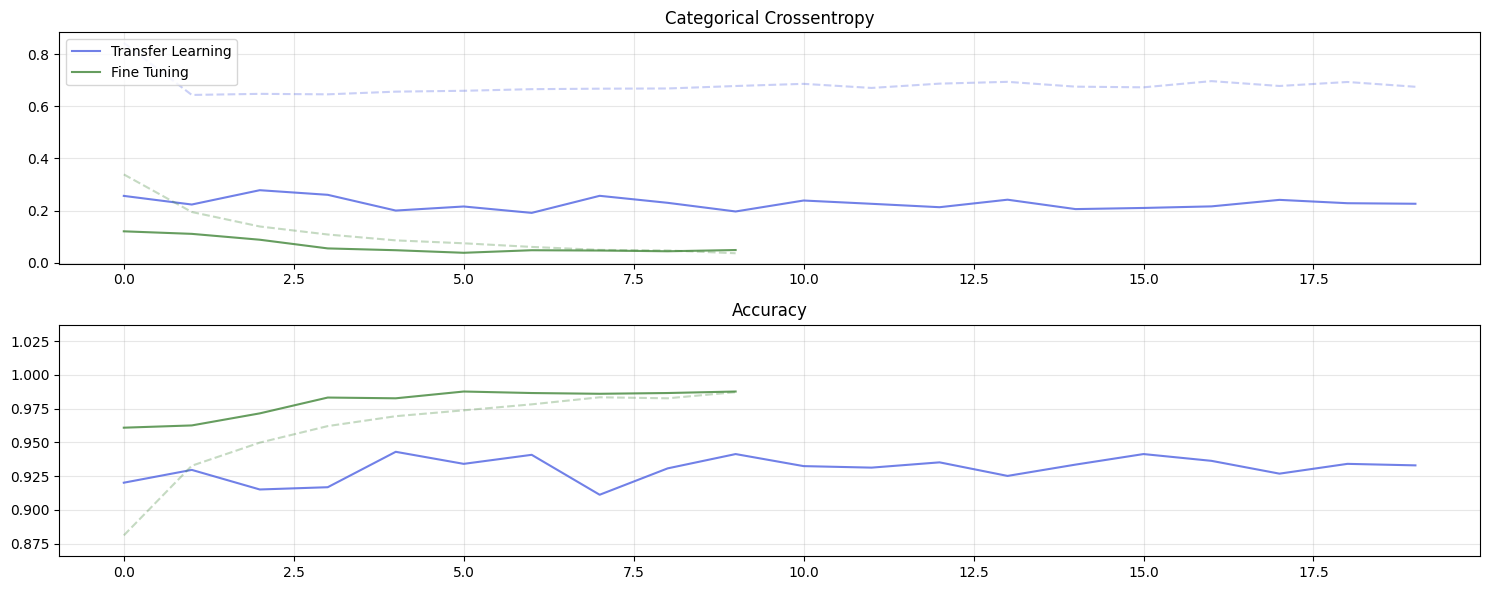

In [28]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine Tuning stages
ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.plot(ft_history['loss'], alpha=0.3, color='#408537', linestyle='--')
ax1.plot(ft_history['val_loss'], label='Fine Tuning', alpha=0.8, color='#408537')
ax1.set_title('Categorical Crossentropy')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine Tuning stages
ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.plot(ft_history['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=0.8, color='#408537')
ax2.set_title('Accuracy')
ax2.set_ylim([min(tl_history['val_accuracy']) * 0.95, max(ft_history['val_accuracy']) * 1.05])
ax2.grid(alpha=0.3)

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()

Code for model.py :

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk

class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Loads the pre-trained model weights.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def preprocess(self, X):
        """
        Preprocess the input data (resize and normalize).

        Args:
        - X (np.ndarray): Input data (images).

        Returns:
        - Preprocessed images.
        """
        # Resize and normalize the images for prediction
        X_resized = tf.image.resize(X, [299, 299]) # * 255
        X_resized = tf.cast(X_resized, tf.float32)   # Convert to float32
        return X_resized

    def predict(self, X):
        """
        Predict the labels corresponding to the input X.

        Args:
        - X (np.ndarray): Dataset of images to predict on.

        Returns:
        - Predictions (np.ndarray): Predicted class labels as integers.
        """
        # Preprocess the input data
        X_preprocessed = self.preprocess(X)

        # Make predictions using the pre-trained model
        preds = self.neural_network.predict(X_preprocessed)

        # If the output is a 2D array (class probabilities), convert it to class labels
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)

        return preds

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
[6 3 6 ... 5 7 7]
